# BehaviorSpace Experiment Analysis

Notebook for organizing and analyzing NetLogo coherence model exports.

**Metrics tracked (v2):**
- `recovery-time`: Ticks from perturbation end to tolerance return
- `baseline`: Rolling 50-tick average of stable variance
- `max-deviation`: Peak deviation from baseline during/after perturbation
- `heading-variance`: Mean absolute angular deviation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

EXPORTS_DIR = Path('../exports')

## 1. Parse BehaviorSpace Spreadsheet Format

BehaviorSpace exports have a complex header structure:
- Rows 1-6: Metadata (version, model, experiment name, timestamp, world bounds)
- Following rows: Parameters and summary stats
- `[all run data]` marker begins time-series data

In [2]:
def parse_behaviorspace_spreadsheet(filepath):
    """
    Parse a BehaviorSpace spreadsheet export.
    Returns metadata dict, parameters dict, and raw dataframe.
    """
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    # Parse metadata
    metadata = {
        'version': lines[0].strip().split(',')[0].strip('"'),
        'model': lines[1].strip().strip('"'),
        'experiment': lines[2].strip().strip('"'),
        'timestamp': lines[3].strip().strip('"')
    }
    
    # Find data start marker
    data_start = None
    for i, line in enumerate(lines):
        if '[all run data]' in line:
            data_start = i
            break
    
    if data_start is None:
        raise ValueError("Could not find [all run data] marker")
    
    # Parse parameters
    params = {}
    for i in range(7, data_start):
        parts = lines[i].strip().split(',')
        if parts and parts[0] and not parts[0].startswith('['):
            param_name = parts[0].strip('"')
            values = [p.strip('"') for p in parts[1:] if p.strip('"')]
            if not param_name.startswith('['):
                params[param_name] = values
    
    # Parse column headers
    header_line = lines[data_start].strip().split(',')
    col_names = [h.strip('"') for h in header_line]
    
    # Read data
    df = pd.read_csv(filepath, skiprows=data_start+1, header=None)
    df.columns = col_names[:len(df.columns)]
    
    # Drop empty first column
    if df.columns[0] == '' or df.columns[0] == '[all run data]':
        df = df.iloc[:, 1:]
    
    return metadata, params, df

In [3]:
def detect_metrics_version(df):
    """
    Detect which metrics version the export uses.
    v1: step, last-recovery-time, heading-variance (3 cols per run)
    v2: step, recovery-time, baseline, max-deviation, heading-variance (5 cols per run)
    """
    cols = list(df.columns)
    if 'baseline' in cols or 'max-deviation' in cols:
        return 'v2', 5
    else:
        return 'v1', 3


def reshape_runs(df):
    """
    Reshape wide-format BehaviorSpace data into long format.
    Auto-detects metrics version.
    """
    version, cols_per_run = detect_metrics_version(df)
    cols = list(df.columns)
    
    runs = []
    i = 0
    run_id = 1
    
    while i < len(cols) - (cols_per_run - 1):
        if 'step' in str(cols[i]).lower():
            run_data = df.iloc[:, i:i+cols_per_run].copy()
            
            if version == 'v2':
                run_data.columns = ['step', 'recovery_time', 'baseline', 'max_deviation', 'heading_variance']
            else:
                run_data.columns = ['step', 'last_recovery_time', 'heading_variance']
            
            run_data['run_id'] = run_id
            runs.append(run_data)
            run_id += 1
            i += cols_per_run
        else:
            i += 1
    
    if runs:
        return pd.concat(runs, ignore_index=True), version
    return df, version

## 2. Load Available Experiments

In [4]:
# List available exports
exports = list(EXPORTS_DIR.glob('*.csv'))
print(f"Found {len(exports)} export files:")
for e in sorted(exports, key=lambda x: x.stat().st_mtime, reverse=True):
    print(f"  - {e.name}")

Found 6 export files:
  - coherence_model_simple E004b_identity_pull_x_perturbation-spreadsheet.csv
  - coherence_model_simple E004a_coupling_x_perturbation-spreadsheet.csv
  - coherence_model_simple_E003-spreadsheet.csv
  - coherence_model_simple_E002-spreadsheet.csv
  - coherence_model_simple Test Experiment 001-spreadsheet.csv
  - coherence_model_simple Heading Variance Over Time.csv


In [5]:
# Load most recent experiment
if exports:
    latest = sorted(exports, key=lambda x: x.stat().st_mtime)[-1]
    print(f"Loading: {latest.name}")
    metadata, params, df = parse_behaviorspace_spreadsheet(latest)
    df_long, version = reshape_runs(df)
    
    print(f"\nExperiment: {metadata['experiment']}")
    print(f"Metrics version: {version}")
    print(f"Runs: {df_long['run_id'].nunique()}")
    print(f"\nParameters:")
    for k, v in params.items():
        print(f"  {k}: {v}")

Loading: coherence_model_simple E004b_identity_pull_x_perturbation-spreadsheet.csv

Experiment: E004b_identity_pull_x_perturbation
Metrics version: v2
Runs: 20

Parameters:
  population: ['150', '150', '150', '150', '150', '150', '150', '150', '150', '150', '150', '150', '150', '150', '150', '150', '150', '150', '150', '150']
  coupling-strength: ['0.4', '0.4', '0.4', '0.4', '0.4', '0.4', '0.4', '0.4', '0.4', '0.4', '0.4', '0.4', '0.4', '0.4', '0.4', '0.4', '0.4', '0.4', '0.4', '0.4']
  noise-level: ['0.3', '0.3', '0.3', '0.3', '0.3', '0.3', '0.3', '0.3', '0.3', '0.3', '0.3', '0.3', '0.3', '0.3', '0.3', '0.3', '0.3', '0.3', '0.3', '0.3']
  perturb-duration: ['30', '30', '30', '30', '30', '30', '30', '30', '30', '30', '30', '30', '30', '30', '30', '30', '30', '30', '30', '30']
  recovery-tolerance: ['5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5']
  perturbation-regime: ['single', 'single', 'single', 'single', 'single', 'single', 'singl

## 3. Build Condition Labels

In [6]:
def build_conditions(params):
    """
    Build condition mapping from parameters.
    """
    n_runs = len(params.get('entrainment-mode?', []))
    conditions = {}
    
    for i in range(n_runs):
        cond = {'run_id': i + 1}
        
        if 'entrainment-mode?' in params:
            cond['entrainment'] = params['entrainment-mode?'][i]
            cond['mode'] = 'Entrainment' if cond['entrainment'] == 'true' else 'Coherence'
        
        if 'perturbation-strength' in params:
            cond['strength'] = int(params['perturbation-strength'][i])
        
        conditions[i + 1] = cond
    
    return conditions

if 'params' in dir():
    conditions = build_conditions(params)
    print("Conditions:")
    for run_id, cond in conditions.items():
        print(f"  Run {run_id}: {cond}")

Conditions:
  Run 1: {'run_id': 1, 'entrainment': 'false', 'mode': 'Coherence', 'strength': 20}
  Run 2: {'run_id': 2, 'entrainment': 'false', 'mode': 'Coherence', 'strength': 30}
  Run 3: {'run_id': 3, 'entrainment': 'false', 'mode': 'Coherence', 'strength': 40}
  Run 4: {'run_id': 4, 'entrainment': 'false', 'mode': 'Coherence', 'strength': 60}
  Run 5: {'run_id': 5, 'entrainment': 'false', 'mode': 'Coherence', 'strength': 80}
  Run 6: {'run_id': 6, 'entrainment': 'false', 'mode': 'Coherence', 'strength': 20}
  Run 7: {'run_id': 7, 'entrainment': 'false', 'mode': 'Coherence', 'strength': 30}
  Run 8: {'run_id': 8, 'entrainment': 'false', 'mode': 'Coherence', 'strength': 40}
  Run 9: {'run_id': 9, 'entrainment': 'false', 'mode': 'Coherence', 'strength': 60}
  Run 10: {'run_id': 10, 'entrainment': 'false', 'mode': 'Coherence', 'strength': 80}
  Run 11: {'run_id': 11, 'entrainment': 'false', 'mode': 'Coherence', 'strength': 20}
  Run 12: {'run_id': 12, 'entrainment': 'false', 'mode': 'Co

## 4. Summary Statistics

In [7]:
def compute_summary(df_long, conditions, version='v2'):
    """
    Compute summary statistics for each run.
    """
    results = []
    
    for run_id, cond in conditions.items():
        run_data = df_long[df_long['run_id'] == run_id]
        final = run_data.iloc[-1]
        
        result = {
            'run_id': run_id,
            'mode': cond.get('mode', 'Unknown'),
            'strength': cond.get('strength', 0),
            'mean_hv': run_data['heading_variance'].mean(),
            'std_hv': run_data['heading_variance'].std(),
        }
        
        if version == 'v2':
            result['recovery_time'] = final['recovery_time']
            result['baseline'] = final['baseline']
            result['max_deviation'] = final['max_deviation']
        else:
            result['last_recovery_time'] = final.get('last_recovery_time', -1)
        
        results.append(result)
    
    return pd.DataFrame(results)

if 'df_long' in dir() and 'conditions' in dir():
    summary_df = compute_summary(df_long, conditions, version)
    print(summary_df.to_string(index=False))

 run_id      mode  strength    mean_hv   std_hv  recovery_time   baseline  max_deviation
      1 Coherence        20  91.249052 4.281831            0.0  86.458504       4.106393
      2 Coherence        30 113.513592 3.637162            0.0 116.813327       5.100369
      3 Coherence        40  90.319428 4.825957           12.0  89.418780      12.151593
      4 Coherence        60  85.685523 5.531170            6.0  85.384635      13.123980
      5 Coherence        80  88.355495 5.177000            0.0  93.060605       7.724099
      6 Coherence        20  89.923248 3.115548            0.0  85.289088       4.255114
      7 Coherence        30  83.495900 2.411886            0.0  85.050579       6.954624
      8 Coherence        40  84.861083 2.866049            0.0  87.062642       4.987444
      9 Coherence        60  87.232257 2.869351            0.0  86.182422       5.750892
     10 Coherence        80  86.873339 2.761835            0.0  84.779190       7.197222
     11 Coherence    

## 5. Visualizations

/var/folders/sp/4sbz_xd134j43tbqp4bzg_5r0000gp/T/ipykernel_87307/4093967257.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


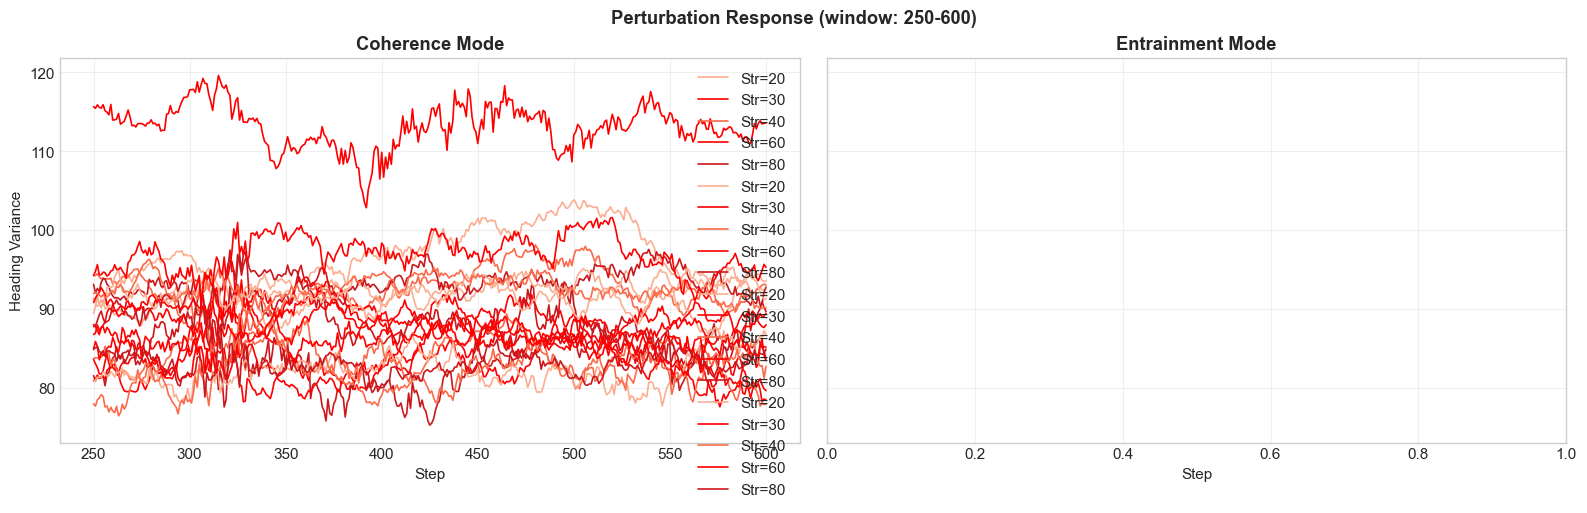

In [8]:
def plot_time_series_comparison(df_long, conditions, window=None):
    """
    Plot heading variance time series, split by mode.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
    
    coh_colors = {10: '#fee5d9', 20: '#fcae91', 40: '#fb6a4a', 80: '#cb181d'}
    ent_colors = {10: '#edf8e9', 20: '#bae4b3', 40: '#74c476', 80: '#238b45'}
    
    for run_id, cond in conditions.items():
        run_data = df_long[df_long['run_id'] == run_id]
        
        if window:
            run_data = run_data[(run_data['step'] >= window[0]) & (run_data['step'] <= window[1])]
        
        strength = cond.get('strength', 0)
        
        if cond.get('mode') == 'Coherence':
            ax = axes[0]
            color = coh_colors.get(strength, 'red')
        else:
            ax = axes[1]
            color = ent_colors.get(strength, 'green')
        
        ax.plot(run_data['step'], run_data['heading_variance'], 
                color=color, label=f'Str={strength}', linewidth=1.2)
    
    axes[0].set_title('Coherence Mode', fontweight='bold')
    axes[0].set_ylabel('Heading Variance')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_title('Entrainment Mode', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    for ax in axes:
        ax.set_xlabel('Step')
        if window is None:
            ax.axvline(x=300, color='gray', linestyle='--', alpha=0.5)
            ax.axvline(x=330, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    return fig, axes

if 'df_long' in dir() and 'conditions' in dir():
    fig, axes = plot_time_series_comparison(df_long, conditions, window=(250, 600))
    plt.suptitle('Perturbation Response (window: 250-600)', y=1.02, fontweight='bold')
    plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5,) and arg 1 with shape (20,).

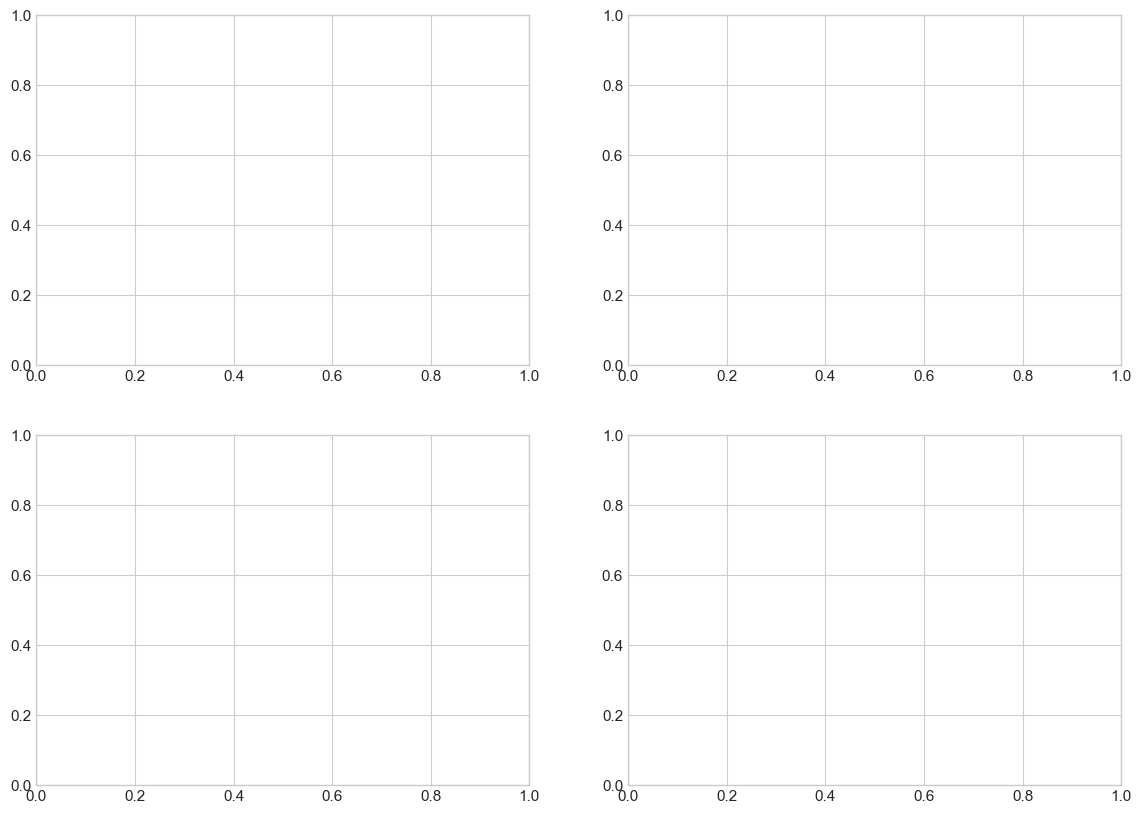

In [9]:
def plot_theorem_validation(summary_df):
    """
    Plot recovery time and max deviation comparison (v2 metrics).
    """
    if 'recovery_time' not in summary_df.columns:
        print("v2 metrics not available")
        return None, None
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    strengths = sorted(summary_df['strength'].unique())
    x = np.arange(len(strengths))
    width = 0.35
    
    coh = summary_df[summary_df['mode'] == 'Coherence'].sort_values('strength')
    ent = summary_df[summary_df['mode'] == 'Entrainment'].sort_values('strength')
    
    # Recovery Time
    ax1 = axes[0, 0]
    bars1 = ax1.bar(x - width/2, coh['recovery_time'], width, label='Coherence', color='#e74c3c', alpha=0.8)
    bars2 = ax1.bar(x + width/2, ent['recovery_time'], width, label='Entrainment', color='#2ecc71', alpha=0.8)
    for bar, val in zip(bars1, coh['recovery_time']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{val:.0f}', ha='center', fontsize=10, fontweight='bold')
    for bar, val in zip(bars2, ent['recovery_time']):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{val:.0f}', ha='center', fontsize=10, fontweight='bold')
    ax1.set_ylabel('Recovery Time (ticks)')
    ax1.set_title('Recovery Time', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(strengths)
    ax1.set_xlabel('Perturbation Strength')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Max Deviation
    ax2 = axes[0, 1]
    bars1 = ax2.bar(x - width/2, coh['max_deviation'], width, label='Coherence', color='#e74c3c', alpha=0.8)
    bars2 = ax2.bar(x + width/2, ent['max_deviation'], width, label='Entrainment', color='#2ecc71', alpha=0.8)
    for bar, val in zip(bars1, coh['max_deviation']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}', ha='center', fontsize=10)
    for bar, val in zip(bars2, ent['max_deviation']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}', ha='center', fontsize=10)
    ax2.set_ylabel('Max Deviation from Baseline')
    ax2.set_title('Peak Disruption', fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(strengths)
    ax2.set_xlabel('Perturbation Strength')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Baseline
    ax3 = axes[1, 0]
    ax3.bar(x - width/2, coh['baseline'], width, label='Coherence', color='#e74c3c', alpha=0.8)
    ax3.bar(x + width/2, ent['baseline'], width, label='Entrainment', color='#2ecc71', alpha=0.8)
    ax3.set_ylabel('Stable Baseline Variance')
    ax3.set_title('Stable Baseline', fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(strengths)
    ax3.set_xlabel('Perturbation Strength')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Ratios
    ax4 = axes[1, 1]
    coh_recovery = coh['recovery_time'].values
    ent_recovery = ent['recovery_time'].values
    coh_maxdev = coh['max_deviation'].values
    ent_maxdev = ent['max_deviation'].values
    
    recovery_ratio = [e/c if c > 0 else 0 for c, e in zip(coh_recovery, ent_recovery)]
    maxdev_ratio = [e/c if c > 0 else 1 for c, e in zip(coh_maxdev, ent_maxdev)]
    
    ax4.bar(x - width/2, recovery_ratio, width, label='Recovery Ratio (Ent/Coh)', color='#3498db', alpha=0.8)
    ax4.bar(x + width/2, maxdev_ratio, width, label='MaxDev Ratio (Ent/Coh)', color='#9b59b6', alpha=0.8)
    ax4.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
    ax4.set_ylabel('Ratio (Entrainment / Coherence)')
    ax4.set_title('Stress Amplification Ratios', fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(strengths)
    ax4.set_xlabel('Perturbation Strength')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig, axes

if 'summary_df' in dir():
    fig, axes = plot_theorem_validation(summary_df)
    if fig:
        plt.suptitle('Coherence Theorem Validation', y=1.02, fontsize=14, fontweight='bold')
        plt.show()

## 6. Export Analysis

In [ ]:
def print_theorem_summary(summary_df):
    """
    Print formatted theorem validation summary.
    """
    if 'recovery_time' not in summary_df.columns:
        print("v2 metrics required")
        return
    
    print("=" * 60)
    print("COHERENCE THEOREM VALIDATION SUMMARY")
    print("=" * 60)
    
    coh = summary_df[summary_df['mode'] == 'Coherence'].sort_values('strength')
    ent = summary_df[summary_df['mode'] == 'Entrainment'].sort_values('strength')
    
    print("\n--- Recovery Time (ticks) ---")
    print(f"{'Strength':<10} {'Coherence':<12} {'Entrainment':<12} {'Ratio':<10}")
    for (_, c), (_, e) in zip(coh.iterrows(), ent.iterrows()):
        ratio = e['recovery_time'] / c['recovery_time'] if c['recovery_time'] > 0 else 'inf'
        ratio_str = f"{ratio:.1f}x" if isinstance(ratio, float) else ratio
        print(f"{c['strength']:<10} {c['recovery_time']:<12.0f} {e['recovery_time']:<12.0f} {ratio_str:<10}")
    
    print("\n--- Peak Disruption (max deviation) ---")
    print(f"{'Strength':<10} {'Coherence':<12} {'Entrainment':<12} {'Ratio':<10}")
    for (_, c), (_, e) in zip(coh.iterrows(), ent.iterrows()):
        ratio = e['max_deviation'] / c['max_deviation'] if c['max_deviation'] > 0 else 'inf'
        ratio_str = f"{ratio:.1f}x" if isinstance(ratio, float) else ratio
        print(f"{c['strength']:<10} {c['max_deviation']:<12.1f} {e['max_deviation']:<12.1f} {ratio_str:<10}")
    
    print("\n--- Baseline Variance ---")
    print(f"{'Strength':<10} {'Coherence':<12} {'Entrainment':<12}")
    for (_, c), (_, e) in zip(coh.iterrows(), ent.iterrows()):
        print(f"{c['strength']:<10} {c['baseline']:<12.1f} {e['baseline']:<12.1f}")
    
    print("\n" + "=" * 60)

if 'summary_df' in dir():
    print_theorem_summary(summary_df)

## 7. Load Specific Experiment

In [ ]:
def load_experiment(filename):
    """
    Load a specific experiment by filename.
    """
    filepath = EXPORTS_DIR / filename
    if not filepath.exists():
        print(f"File not found: {filepath}")
        return None, None, None, None, None
    
    metadata, params, df = parse_behaviorspace_spreadsheet(filepath)
    df_long, version = reshape_runs(df)
    conditions = build_conditions(params)
    summary_df = compute_summary(df_long, conditions, version)
    
    print(f"Loaded: {metadata['experiment']}")
    print(f"Metrics version: {version}")
    print(f"Runs: {len(conditions)}")
    
    return metadata, params, df_long, conditions, summary_df

# Example usage:
# metadata, params, df_long, conditions, summary_df = load_experiment('coherence_model_simple_E003-spreadsheet.csv')

---

## Experiment Registry

| File | Experiment | Date | Notes |
|------|------------|------|-------|
| coherence_model_simple_E002-spreadsheet.csv | E02_mode_contrast_periodic | 2025-12-26 | Periodic perturbation, entrainment vs coherence |
| coherence_model_simple_E003-spreadsheet.csv | E003_stress_scaling_response | 2025-12-26 | Single perturbation, stress scaling (10-80), theorem validation |
| coherence_model_simple E004a_coupling_x_perturbation-spreadsheet.csv | E004a | 2025-12-26 | Coupling × Mode × Perturbation threshold mapping |
| coherence_model_simple E004b_identity_pull_x_perturbation-spreadsheet.csv | E004b | 2025-12-26 | Identity-pull × Perturbation (coherence only) |

## 8. E004 Analysis: Threshold Surface Mapping

Extended analysis for E004a (Coupling × Mode × Perturbation) and E004b (Identity-Pull × Perturbation).

In [ ]:
def build_conditions_extended(params):
    """
    Build condition mapping with extended parameters for E004 experiments.
    """
    # Find the number of runs from the first parameter list
    first_param = list(params.values())[0]
    n_runs = len(first_param)
    conditions = {}
    
    for i in range(n_runs):
        cond = {'run_id': i + 1}
        
        if 'entrainment-mode?' in params:
            cond['entrainment'] = params['entrainment-mode?'][i]
            cond['mode'] = 'Entrainment' if cond['entrainment'] == 'true' else 'Coherence'
        
        if 'perturbation-strength' in params:
            cond['strength'] = int(params['perturbation-strength'][i])
        
        if 'coupling-strength' in params:
            cond['coupling'] = float(params['coupling-strength'][i])
        
        if 'identity-pull-weight' in params:
            cond['identity_pull'] = float(params['identity-pull-weight'][i])
        
        if 'social-pull-weight' in params:
            cond['social_pull'] = float(params['social-pull-weight'][i])
        
        conditions[i + 1] = cond
    
    return conditions


def compute_summary_extended(df_long, conditions, version='v2'):
    """
    Compute summary statistics with extended parameters.
    """
    results = []
    
    for run_id, cond in conditions.items():
        run_data = df_long[df_long['run_id'] == run_id]
        if len(run_data) == 0:
            continue
        final = run_data.iloc[-1]
        
        result = {
            'run_id': run_id,
            'mode': cond.get('mode', 'Coherence'),
            'strength': cond.get('strength', 0),
            'coupling': cond.get('coupling', 0.4),
            'identity_pull': cond.get('identity_pull', 0.2),
            'social_pull': cond.get('social_pull', 0.5),
            'mean_hv': run_data['heading_variance'].mean(),
            'std_hv': run_data['heading_variance'].std(),
        }
        
        if version == 'v2':
            result['recovery_time'] = final['recovery_time']
            result['baseline'] = final['baseline']
            result['max_deviation'] = final['max_deviation']
        else:
            result['last_recovery_time'] = final.get('last_recovery_time', -1)
        
        results.append(result)
    
    return pd.DataFrame(results)


def load_experiment_extended(filename):
    """
    Load experiment with extended parameter handling.
    """
    filepath = EXPORTS_DIR / filename
    if not filepath.exists():
        print(f"File not found: {filepath}")
        return None, None, None, None, None
    
    metadata, params, df = parse_behaviorspace_spreadsheet(filepath)
    df_long, version = reshape_runs(df)
    conditions = build_conditions_extended(params)
    summary_df = compute_summary_extended(df_long, conditions, version)
    
    print(f"Loaded: {metadata['experiment']}")
    print(f"Metrics version: {version}")
    print(f"Runs: {len(conditions)}")
    
    return metadata, params, df_long, conditions, summary_df

### 8.1 E004a: Coupling × Mode × Perturbation

In [ ]:
def plot_e004a_coupling_threshold(summary_df):
    """
    Plot E004a results: Recovery time and max deviation by coupling strength and mode.
    """
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    couplings = sorted(summary_df['coupling'].unique())
    strengths = sorted(summary_df['strength'].unique())
    
    colors_coh = plt.cm.Reds(np.linspace(0.3, 0.9, len(strengths)))
    colors_ent = plt.cm.Greens(np.linspace(0.3, 0.9, len(strengths)))
    
    # Top row: Recovery time by coupling (one subplot per coupling)
    for idx, coupling in enumerate(couplings):
        ax = axes[0, idx]
        subset = summary_df[summary_df['coupling'] == coupling]
        
        x = np.arange(len(strengths))
        width = 0.35
        
        coh = subset[subset['mode'] == 'Coherence'].sort_values('strength')
        ent = subset[subset['mode'] == 'Entrainment'].sort_values('strength')
        
        # Handle DNR (-1 values) - cap at 600 for display
        coh_vals = coh['recovery_time'].clip(lower=0, upper=600).values
        ent_vals = ent['recovery_time'].clip(lower=0, upper=600).values
        
        bars1 = ax.bar(x - width/2, coh_vals, width, label='Coherence', color='#e74c3c', alpha=0.8)
        bars2 = ax.bar(x + width/2, ent_vals, width, label='Entrainment', color='#2ecc71', alpha=0.8)
        
        # Add value labels
        for bar, val in zip(bars1, coh['recovery_time'].values):
            label = 'DNR' if val < 0 else f'{val:.0f}'
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, label, 
                    ha='center', fontsize=8, fontweight='bold')
        for bar, val in zip(bars2, ent['recovery_time'].values):
            label = 'DNR' if val < 0 else f'{val:.0f}'
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, label, 
                    ha='center', fontsize=8, fontweight='bold')
        
        ax.set_title(f'Coupling = {coupling}', fontweight='bold')
        ax.set_ylabel('Recovery Time (ticks)')
        ax.set_xticks(x)
        ax.set_xticklabels(strengths)
        ax.set_xlabel('Perturbation Strength')
        ax.legend(loc='upper left', fontsize=8)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim(0, max(ent_vals.max(), coh_vals.max()) * 1.2 + 20)
    
    # Bottom row: Max deviation by coupling
    for idx, coupling in enumerate(couplings):
        ax = axes[1, idx]
        subset = summary_df[summary_df['coupling'] == coupling]
        
        x = np.arange(len(strengths))
        width = 0.35
        
        coh = subset[subset['mode'] == 'Coherence'].sort_values('strength')
        ent = subset[subset['mode'] == 'Entrainment'].sort_values('strength')
        
        bars1 = ax.bar(x - width/2, coh['max_deviation'], width, label='Coherence', color='#e74c3c', alpha=0.8)
        bars2 = ax.bar(x + width/2, ent['max_deviation'], width, label='Entrainment', color='#2ecc71', alpha=0.8)
        
        ax.set_title(f'Coupling = {coupling}', fontweight='bold')
        ax.set_ylabel('Max Deviation (degrees)')
        ax.set_xticks(x)
        ax.set_xticklabels(strengths)
        ax.set_xlabel('Perturbation Strength')
        ax.legend(loc='upper left', fontsize=8)
        ax.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('E004a: Coupling × Mode × Perturbation\nRecovery Time (top) | Max Deviation (bottom)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig, axes


def plot_e004a_threshold_heatmap(summary_df):
    """
    Plot heatmaps showing recovery time by mode, coupling, and perturbation.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for idx, mode in enumerate(['Coherence', 'Entrainment']):
        ax = axes[idx]
        subset = summary_df[summary_df['mode'] == mode]
        
        # Pivot to create heatmap data
        pivot = subset.pivot(index='coupling', columns='strength', values='recovery_time')
        
        # Replace -1 (DNR) with a high value for color mapping
        pivot_display = pivot.replace(-1, 600)
        
        im = ax.imshow(pivot_display.values, cmap='YlOrRd', aspect='auto', vmin=0, vmax=300)
        
        ax.set_xticks(range(len(pivot.columns)))
        ax.set_xticklabels(pivot.columns)
        ax.set_yticks(range(len(pivot.index)))
        ax.set_yticklabels(pivot.index)
        ax.set_xlabel('Perturbation Strength')
        ax.set_ylabel('Coupling Strength')
        ax.set_title(f'{mode} Mode', fontweight='bold')
        
        # Add text annotations
        for i in range(len(pivot.index)):
            for j in range(len(pivot.columns)):
                val = pivot.values[i, j]
                text = 'DNR' if val < 0 else f'{val:.0f}'
                color = 'white' if pivot_display.values[i, j] > 150 else 'black'
                ax.text(j, i, text, ha='center', va='center', color=color, fontsize=10, fontweight='bold')
        
        plt.colorbar(im, ax=ax, label='Recovery Time (ticks)')
    
    plt.suptitle('E004a: Recovery Time Heatmap by Mode', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig, axes

In [ ]:
# Load E004a
e004a_file = 'coherence_model_simple E004a_coupling_x_perturbation-spreadsheet.csv'
meta_a, params_a, df_a, cond_a, summary_a = load_experiment_extended(e004a_file)

if summary_a is not None:
    print("\nSummary:")
    print(summary_a[['mode', 'coupling', 'strength', 'recovery_time', 'max_deviation', 'baseline']].to_string(index=False))

In [ ]:
# Plot E004a bar charts
if summary_a is not None:
    fig, axes = plot_e004a_coupling_threshold(summary_a)
    plt.savefig(EXPORTS_DIR / 'E004a_coupling_threshold_bars.png', dpi=150, bbox_inches='tight')
    plt.show()

In [ ]:
# Plot E004a heatmaps
if summary_a is not None:
    fig, axes = plot_e004a_threshold_heatmap(summary_a)
    plt.savefig(EXPORTS_DIR / 'E004a_recovery_heatmap.png', dpi=150, bbox_inches='tight')
    plt.show()

### 8.2 E004b: Identity-Pull × Perturbation (Coherence Mode Only)

In [ ]:
def plot_e004b_identity_pull(summary_df):
    """
    Plot E004b results: Recovery time and max deviation by identity-pull weight.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    identity_pulls = sorted(summary_df['identity_pull'].unique())
    strengths = sorted(summary_df['strength'].unique())
    
    colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(identity_pulls)))
    
    # Top-left: Recovery time by identity-pull
    ax = axes[0, 0]
    x = np.arange(len(strengths))
    width = 0.8 / len(identity_pulls)
    
    for idx, ip in enumerate(identity_pulls):
        subset = summary_df[summary_df['identity_pull'] == ip].sort_values('strength')
        offset = (idx - len(identity_pulls)/2 + 0.5) * width
        bars = ax.bar(x + offset, subset['recovery_time'].clip(lower=0), width, 
                      label=f'IP={ip}', color=colors[idx], alpha=0.8)
    
    ax.set_title('Recovery Time by Identity-Pull Weight', fontweight='bold')
    ax.set_ylabel('Recovery Time (ticks)')
    ax.set_xticks(x)
    ax.set_xticklabels(strengths)
    ax.set_xlabel('Perturbation Strength')
    ax.legend(title='Identity-Pull')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Top-right: Max deviation by identity-pull
    ax = axes[0, 1]
    for idx, ip in enumerate(identity_pulls):
        subset = summary_df[summary_df['identity_pull'] == ip].sort_values('strength')
        offset = (idx - len(identity_pulls)/2 + 0.5) * width
        ax.bar(x + offset, subset['max_deviation'], width, 
               label=f'IP={ip}', color=colors[idx], alpha=0.8)
    
    ax.set_title('Max Deviation by Identity-Pull Weight', fontweight='bold')
    ax.set_ylabel('Max Deviation (degrees)')
    ax.set_xticks(x)
    ax.set_xticklabels(strengths)
    ax.set_xlabel('Perturbation Strength')
    ax.legend(title='Identity-Pull')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Bottom-left: Line plot of max deviation vs perturbation strength
    ax = axes[1, 0]
    for idx, ip in enumerate(identity_pulls):
        subset = summary_df[summary_df['identity_pull'] == ip].sort_values('strength')
        ax.plot(subset['strength'], subset['max_deviation'], 'o-', 
                color=colors[idx], label=f'IP={ip}', linewidth=2, markersize=8)
    
    ax.set_title('Max Deviation Scaling', fontweight='bold')
    ax.set_ylabel('Max Deviation (degrees)')
    ax.set_xlabel('Perturbation Strength')
    ax.legend(title='Identity-Pull')
    ax.grid(True, alpha=0.3)
    
    # Bottom-right: Heatmap of max deviation
    ax = axes[1, 1]
    pivot = summary_df.pivot(index='identity_pull', columns='strength', values='max_deviation')
    
    im = ax.imshow(pivot.values, cmap='YlOrRd', aspect='auto')
    
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns)
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xlabel('Perturbation Strength')
    ax.set_ylabel('Identity-Pull Weight')
    ax.set_title('Max Deviation Heatmap', fontweight='bold')
    
    # Add text annotations
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            val = pivot.values[i, j]
            color = 'white' if val > pivot.values.max() * 0.6 else 'black'
            ax.text(j, i, f'{val:.1f}', ha='center', va='center', color=color, fontsize=10)
    
    plt.colorbar(im, ax=ax, label='Max Deviation (degrees)')
    
    plt.suptitle('E004b: Identity-Pull × Perturbation (Coherence Mode)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig, axes


def plot_e004b_summary_stats(summary_df):
    """
    Plot summary statistics for E004b.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    identity_pulls = sorted(summary_df['identity_pull'].unique())
    
    # Average recovery time
    ax = axes[0]
    avg_recovery = [summary_df[summary_df['identity_pull'] == ip]['recovery_time'].clip(lower=0).mean() 
                    for ip in identity_pulls]
    bars = ax.bar(identity_pulls, avg_recovery, width=0.08, color='#3498db', alpha=0.8)
    for bar, val in zip(bars, avg_recovery):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, f'{val:.1f}', 
                ha='center', fontsize=11, fontweight='bold')
    ax.set_xlabel('Identity-Pull Weight')
    ax.set_ylabel('Average Recovery Time (ticks)')
    ax.set_title('Avg Recovery Time by Identity-Pull', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Average max deviation
    ax = axes[1]
    avg_maxdev = [summary_df[summary_df['identity_pull'] == ip]['max_deviation'].mean() 
                  for ip in identity_pulls]
    bars = ax.bar(identity_pulls, avg_maxdev, width=0.08, color='#e74c3c', alpha=0.8)
    for bar, val in zip(bars, avg_maxdev):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, f'{val:.1f}', 
                ha='center', fontsize=11, fontweight='bold')
    ax.set_xlabel('Identity-Pull Weight')
    ax.set_ylabel('Average Max Deviation (degrees)')
    ax.set_title('Avg Max Deviation by Identity-Pull', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('E004b Summary: Effect of Identity-Pull Weight', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig, axes

In [ ]:
# Load E004b
e004b_file = 'coherence_model_simple E004b_identity_pull_x_perturbation-spreadsheet.csv'
meta_b, params_b, df_b, cond_b, summary_b = load_experiment_extended(e004b_file)

if summary_b is not None:
    print("\nSummary:")
    print(summary_b[['identity_pull', 'strength', 'recovery_time', 'max_deviation', 'baseline']].to_string(index=False))

In [ ]:
# Plot E004b detailed
if summary_b is not None:
    fig, axes = plot_e004b_identity_pull(summary_b)
    plt.savefig(EXPORTS_DIR / 'E004b_identity_pull_detailed.png', dpi=150, bbox_inches='tight')
    plt.show()

In [10]:
# Plot E004b summary
if summary_b is not None:
    fig, axes = plot_e004b_summary_stats(summary_b)
    plt.savefig(EXPORTS_DIR / 'E004b_identity_pull_summary.png', dpi=150, bbox_inches='tight')
    plt.show()

NameError: name 'summary_b' is not defined

## 9. E005 Analysis: Cost Metrics

Analysis for E005a (Cost Mode Contrast) and E005b (Cost Distribution).

**Cost Metrics (v1):**
- `mean-metabolic-cost`: Average per-agent continuous regulatory cost
- `mean-shock-cost`: Average per-agent perturbation cost
- `mean-recovery-cost`: Average per-agent recovery cost
- `mean-cumulative-cost`: Total cost (sum of all types)
- `cost-variance`: Variance in cumulative cost across agents
- `cost-gini`: Gini coefficient (0=equal distribution, 1=concentrated)

In [ ]:
def detect_cost_metrics(df):
    """
    Check if dataframe has cost metrics columns.
    """
    cost_cols = ['mean-metabolic-cost', 'mean-shock-cost', 'mean-recovery-cost', 
                 'mean-cumulative-cost', 'cost-variance', 'cost-gini']
    cols = [str(c).lower().replace('_', '-') for c in df.columns]
    return any(c in cols for c in cost_cols)


def reshape_runs_with_costs(df):
    """
    Reshape wide-format BehaviorSpace data including cost metrics.
    Handles v2 metrics (5 cols) + cost metrics (6 cols) = 11 cols per run.
    """
    cols = list(df.columns)
    
    # Check for cost metrics
    has_costs = detect_cost_metrics(df)
    
    if has_costs:
        # v2 + costs: step, recovery-time, baseline, max-deviation, heading-variance,
        #             mean-metabolic-cost, mean-shock-cost, mean-recovery-cost,
        #             mean-cumulative-cost, cost-variance, cost-gini
        cols_per_run = 11
        col_names = ['step', 'recovery_time', 'baseline', 'max_deviation', 'heading_variance',
                     'mean_metabolic_cost', 'mean_shock_cost', 'mean_recovery_cost',
                     'mean_cumulative_cost', 'cost_variance', 'cost_gini']
    else:
        # Fall back to v2 without costs
        cols_per_run = 5
        col_names = ['step', 'recovery_time', 'baseline', 'max_deviation', 'heading_variance']
    
    runs = []
    i = 0
    run_id = 1
    
    while i < len(cols) - (cols_per_run - 1):
        if 'step' in str(cols[i]).lower():
            run_data = df.iloc[:, i:i+cols_per_run].copy()
            run_data.columns = col_names
            run_data['run_id'] = run_id
            runs.append(run_data)
            run_id += 1
            i += cols_per_run
        else:
            i += 1
    
    if runs:
        return pd.concat(runs, ignore_index=True), has_costs
    return df, has_costs


def load_experiment_with_costs(filename):
    """
    Load experiment with cost metrics support.
    """
    filepath = EXPORTS_DIR / filename
    if not filepath.exists():
        print(f"File not found: {filepath}")
        return None, None, None, None, None, False
    
    metadata, params, df = parse_behaviorspace_spreadsheet(filepath)
    df_long, has_costs = reshape_runs_with_costs(df)
    conditions = build_conditions_extended(params)
    
    print(f"Loaded: {metadata['experiment']}")
    print(f"Has cost metrics: {has_costs}")
    print(f"Runs: {len(conditions)}")
    
    return metadata, params, df_long, conditions, has_costs


def compute_cost_summary(df_long, conditions, has_costs=True):
    """
    Compute summary statistics including cost metrics.
    """
    results = []
    
    for run_id, cond in conditions.items():
        run_data = df_long[df_long['run_id'] == run_id]
        if len(run_data) == 0:
            continue
        final = run_data.iloc[-1]
        
        result = {
            'run_id': run_id,
            'mode': cond.get('mode', 'Coherence'),
            'strength': cond.get('strength', 0),
            'recovery_time': final['recovery_time'],
            'baseline': final['baseline'],
            'max_deviation': final['max_deviation'],
            'mean_hv': run_data['heading_variance'].mean(),
        }
        
        if has_costs:
            result['metabolic_cost'] = final['mean_metabolic_cost']
            result['shock_cost'] = final['mean_shock_cost']
            result['recovery_cost'] = final['mean_recovery_cost']
            result['cumulative_cost'] = final['mean_cumulative_cost']
            result['cost_variance'] = final['cost_variance']
            result['cost_gini'] = final['cost_gini']
        
        results.append(result)
    
    return pd.DataFrame(results)

In [ ]:
def plot_e005_cost_comparison(summary_df):
    """
    Plot E005a results: Cost metrics by mode and perturbation strength.
    """
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    strengths = sorted(summary_df['strength'].unique())
    x = np.arange(len(strengths))
    width = 0.35
    
    coh = summary_df[summary_df['mode'] == 'Coherence'].sort_values('strength')
    ent = summary_df[summary_df['mode'] == 'Entrainment'].sort_values('strength')
    
    # 1. Cumulative Cost
    ax = axes[0, 0]
    ax.bar(x - width/2, coh['cumulative_cost'], width, label='Coherence', color='#e74c3c', alpha=0.8)
    ax.bar(x + width/2, ent['cumulative_cost'], width, label='Entrainment', color='#2ecc71', alpha=0.8)
    ax.set_title('Cumulative Cost', fontweight='bold')
    ax.set_ylabel('Mean Cumulative Cost')
    ax.set_xticks(x)
    ax.set_xticklabels(strengths)
    ax.set_xlabel('Perturbation Strength')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 2. Cost Gini
    ax = axes[0, 1]
    bars1 = ax.bar(x - width/2, coh['cost_gini'], width, label='Coherence', color='#e74c3c', alpha=0.8)
    bars2 = ax.bar(x + width/2, ent['cost_gini'], width, label='Entrainment', color='#2ecc71', alpha=0.8)
    for bar, val in zip(bars1, coh['cost_gini']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, f'{val:.3f}', 
                ha='center', fontsize=9, fontweight='bold')
    for bar, val in zip(bars2, ent['cost_gini']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, f'{val:.3f}', 
                ha='center', fontsize=9, fontweight='bold')
    ax.set_title('Cost Gini Coefficient', fontweight='bold')
    ax.set_ylabel('Gini (0=equal, 1=concentrated)')
    ax.set_xticks(x)
    ax.set_xticklabels(strengths)
    ax.set_xlabel('Perturbation Strength')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 3. Recovery Time (for reference)
    ax = axes[0, 2]
    bars1 = ax.bar(x - width/2, coh['recovery_time'].clip(lower=0), width, label='Coherence', color='#e74c3c', alpha=0.8)
    bars2 = ax.bar(x + width/2, ent['recovery_time'].clip(lower=0), width, label='Entrainment', color='#2ecc71', alpha=0.8)
    for bar, val in zip(bars1, coh['recovery_time']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{val:.0f}', 
                ha='center', fontsize=9, fontweight='bold')
    for bar, val in zip(bars2, ent['recovery_time']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{val:.0f}', 
                ha='center', fontsize=9, fontweight='bold')
    ax.set_title('Recovery Time', fontweight='bold')
    ax.set_ylabel('Ticks')
    ax.set_xticks(x)
    ax.set_xticklabels(strengths)
    ax.set_xlabel('Perturbation Strength')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 4. Cost Breakdown - Coherence
    ax = axes[1, 0]
    ax.bar(x, coh['metabolic_cost'], width*1.5, label='Metabolic', color='#3498db', alpha=0.8)
    ax.bar(x, coh['shock_cost'], width*1.5, bottom=coh['metabolic_cost'], label='Shock', color='#e74c3c', alpha=0.8)
    ax.bar(x, coh['recovery_cost'], width*1.5, bottom=coh['metabolic_cost']+coh['shock_cost'], 
           label='Recovery', color='#f39c12', alpha=0.8)
    ax.set_title('Cost Breakdown: Coherence', fontweight='bold')
    ax.set_ylabel('Cost')
    ax.set_xticks(x)
    ax.set_xticklabels(strengths)
    ax.set_xlabel('Perturbation Strength')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 5. Cost Breakdown - Entrainment
    ax = axes[1, 1]
    ax.bar(x, ent['metabolic_cost'], width*1.5, label='Metabolic', color='#3498db', alpha=0.8)
    ax.bar(x, ent['shock_cost'], width*1.5, bottom=ent['metabolic_cost'], label='Shock', color='#e74c3c', alpha=0.8)
    ax.bar(x, ent['recovery_cost'], width*1.5, bottom=ent['metabolic_cost']+ent['shock_cost'], 
           label='Recovery', color='#f39c12', alpha=0.8)
    ax.set_title('Cost Breakdown: Entrainment', fontweight='bold')
    ax.set_ylabel('Cost')
    ax.set_xticks(x)
    ax.set_xticklabels(strengths)
    ax.set_xlabel('Perturbation Strength')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 6. Gini Ratio (Coherence / Entrainment)
    ax = axes[1, 2]
    gini_ratio = coh['cost_gini'].values / ent['cost_gini'].values
    bars = ax.bar(x, gini_ratio, width*1.5, color='#9b59b6', alpha=0.8)
    ax.axhline(y=1, color='gray', linestyle='--', alpha=0.7, label='Equal')
    for bar, val in zip(bars, gini_ratio):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, f'{val:.2f}x', 
                ha='center', fontsize=10, fontweight='bold')
    ax.set_title('Gini Ratio (Coherence / Entrainment)', fontweight='bold')
    ax.set_ylabel('Ratio')
    ax.set_xticks(x)
    ax.set_xticklabels(strengths)
    ax.set_xlabel('Perturbation Strength')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('E005a: Cost Mode Contrast\nCoherence vs Entrainment', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig, axes


def plot_cost_time_series(df_long, conditions):
    """
    Plot cost accumulation over time for each mode.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    coh_colors = {10: '#fee5d9', 20: '#fcae91', 40: '#fb6a4a', 80: '#cb181d'}
    ent_colors = {10: '#edf8e9', 20: '#bae4b3', 40: '#74c476', 80: '#238b45'}
    
    # Cumulative cost over time
    for run_id, cond in conditions.items():
        run_data = df_long[df_long['run_id'] == run_id]
        strength = cond.get('strength', 0)
        
        if cond.get('mode') == 'Coherence':
            ax = axes[0, 0]
            color = coh_colors.get(strength, 'red')
        else:
            ax = axes[0, 1]
            color = ent_colors.get(strength, 'green')
        
        ax.plot(run_data['step'], run_data['mean_cumulative_cost'], 
                color=color, label=f'Str={strength}', linewidth=1.5)
    
    axes[0, 0].set_title('Coherence: Cost Accumulation', fontweight='bold')
    axes[0, 0].set_ylabel('Mean Cumulative Cost')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].set_title('Entrainment: Cost Accumulation', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Gini over time
    for run_id, cond in conditions.items():
        run_data = df_long[df_long['run_id'] == run_id]
        strength = cond.get('strength', 0)
        
        if cond.get('mode') == 'Coherence':
            ax = axes[1, 0]
            color = coh_colors.get(strength, 'red')
        else:
            ax = axes[1, 1]
            color = ent_colors.get(strength, 'green')
        
        ax.plot(run_data['step'], run_data['cost_gini'], 
                color=color, label=f'Str={strength}', linewidth=1.5)
    
    axes[1, 0].set_title('Coherence: Gini Over Time', fontweight='bold')
    axes[1, 0].set_ylabel('Cost Gini')
    axes[1, 0].set_xlabel('Step')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].set_title('Entrainment: Gini Over Time', fontweight='bold')
    axes[1, 1].set_xlabel('Step')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add perturbation markers
    for ax in axes.flat:
        ax.axvline(x=300, color='gray', linestyle='--', alpha=0.5)
        ax.axvline(x=330, color='gray', linestyle='--', alpha=0.5)
    
    plt.suptitle('E005a: Cost Dynamics Over Time', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig, axes


def print_cost_summary(summary_df):
    """
    Print formatted cost summary table.
    """
    print("=" * 80)
    print("E005a COST ANALYSIS SUMMARY")
    print("=" * 80)
    
    coh = summary_df[summary_df['mode'] == 'Coherence'].sort_values('strength')
    ent = summary_df[summary_df['mode'] == 'Entrainment'].sort_values('strength')
    
    print("\n--- Final Cumulative Cost ---")
    print(f"{'Strength':<10} {'Coherence':<15} {'Entrainment':<15} {'Ratio (C/E)':<12}")
    for (_, c), (_, e) in zip(coh.iterrows(), ent.iterrows()):
        ratio = c['cumulative_cost'] / e['cumulative_cost'] if e['cumulative_cost'] > 0 else 0
        print(f"{c['strength']:<10} {c['cumulative_cost']:<15.1f} {e['cumulative_cost']:<15.1f} {ratio:<12.2f}")
    
    print("\n--- Cost Gini (Distribution Inequality) ---")
    print(f"{'Strength':<10} {'Coherence':<15} {'Entrainment':<15} {'Ratio (C/E)':<12}")
    for (_, c), (_, e) in zip(coh.iterrows(), ent.iterrows()):
        ratio = c['cost_gini'] / e['cost_gini'] if e['cost_gini'] > 0 else 0
        print(f"{c['strength']:<10} {c['cost_gini']:<15.4f} {e['cost_gini']:<15.4f} {ratio:<12.2f}")
    
    print("\n--- Recovery Time ---")
    print(f"{'Strength':<10} {'Coherence':<15} {'Entrainment':<15} {'Ratio (E/C)':<12}")
    for (_, c), (_, e) in zip(coh.iterrows(), ent.iterrows()):
        ratio = e['recovery_time'] / c['recovery_time'] if c['recovery_time'] > 0 else float('inf')
        ratio_str = f"{ratio:.1f}" if ratio != float('inf') else "inf"
        print(f"{c['strength']:<10} {c['recovery_time']:<15.0f} {e['recovery_time']:<15.0f} {ratio_str:<12}")
    
    print("\n--- Key Insight ---")
    avg_gini_coh = coh['cost_gini'].mean()
    avg_gini_ent = ent['cost_gini'].mean()
    print(f"Average Gini: Coherence={avg_gini_coh:.4f}, Entrainment={avg_gini_ent:.4f}")
    print(f"Coherence Gini is {avg_gini_coh/avg_gini_ent:.1f}x higher than Entrainment")
    print("\nInterpretation: Coherence preserves agent differences, leading to")
    print("unequal cost distribution. Entrainment homogenizes, spreading cost evenly.")
    print("=" * 80)

### 9.1 Load and Analyze E005a

In [ ]:
# Load E005a
e005a_file = 'coherence_model_simple E005a_cost_mode_contrast-spreadsheet.csv'
meta_e005a, params_e005a, df_e005a, cond_e005a, has_costs = load_experiment_with_costs(e005a_file)

if df_e005a is not None:
    summary_e005a = compute_cost_summary(df_e005a, cond_e005a, has_costs)
    print("\nSummary:")
    print(summary_e005a.to_string(index=False))

In [ ]:
# Print cost summary
if 'summary_e005a' in dir():
    print_cost_summary(summary_e005a)

In [ ]:
# Plot cost comparison
if 'summary_e005a' in dir():
    fig, axes = plot_e005_cost_comparison(summary_e005a)
    plt.savefig(EXPORTS_DIR / 'E005a_cost_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

In [ ]:
# Plot cost time series
if 'df_e005a' in dir() and 'cond_e005a' in dir():
    fig, axes = plot_cost_time_series(df_e005a, cond_e005a)
    plt.savefig(EXPORTS_DIR / 'E005a_cost_time_series.png', dpi=150, bbox_inches='tight')
    plt.show()

## 10. F001 Fatigue Analysis

**Fatigue Metrics (v1):**
- `mean-fatigue-level`: Average fatigue across agents (0-1)
- `max-fatigue-level`: Highest individual fatigue
- `agents-fatigued`: Count of agents above fatigue threshold
- `mean-effective-inertia`: Average turning capacity (increases with fatigue)

**Experiment Design:**
- 2×2 factorial: (entrainment-mode × fatigue-enabled)
- Single perturbation at strength 60
- Tests whether fatigue creates feedback spiral in entrainment

In [ ]:
def reshape_runs_with_fatigue(df):
    """
    Reshape wide-format BehaviorSpace data including fatigue metrics.
    F001 has: step + 4 standard + 6 cost + 4 fatigue = 15 cols per run
    """
    cols = list(df.columns)
    
    # F001 column structure (15 per run)
    cols_per_run = 15
    col_names = ['step', 'recovery_time', 'baseline', 'max_deviation', 'heading_variance',
                 'mean_metabolic_cost', 'mean_shock_cost', 'mean_recovery_cost',
                 'mean_cumulative_cost', 'cost_variance', 'cost_gini',
                 'mean_fatigue_level', 'max_fatigue_level', 'agents_fatigued', 
                 'mean_effective_inertia']
    
    runs = []
    i = 0
    run_id = 1
    
    while i < len(cols) - (cols_per_run - 1):
        if 'step' in str(cols[i]).lower():
            run_data = df.iloc[:, i:i+cols_per_run].copy()
            run_data.columns = col_names
            run_data['run_id'] = run_id
            runs.append(run_data)
            run_id += 1
            i += cols_per_run
        else:
            i += 1
    
    if runs:
        return pd.concat(runs, ignore_index=True)
    return df


def build_f001_conditions(params):
    """
    Build condition mapping for F001 experiment.
    """
    n_runs = len(params.get('entrainment-mode?', []))
    conditions = {}
    
    for i in range(n_runs):
        cond = {'run_id': i + 1}
        
        if 'entrainment-mode?' in params:
            cond['entrainment'] = params['entrainment-mode?'][i]
            cond['mode'] = 'Entrainment' if cond['entrainment'] == 'true' else 'Coherence'
        
        if 'fatigue-enabled?' in params:
            cond['fatigue_enabled'] = params['fatigue-enabled?'][i] == 'true'
            cond['fatigue_label'] = 'Fatigue ON' if cond['fatigue_enabled'] else 'Fatigue OFF'
        
        if 'perturbation-strength' in params:
            cond['strength'] = int(params['perturbation-strength'][i])
        
        # Combined label for plotting
        cond['condition'] = f"{cond['mode']}\n{cond['fatigue_label']}"
        
        conditions[i + 1] = cond
    
    return conditions


def load_f001_experiment(filename):
    """
    Load F001 fatigue experiment.
    """
    filepath = EXPORTS_DIR / filename
    if not filepath.exists():
        print(f"File not found: {filepath}")
        return None, None, None, None
    
    metadata, params, df = parse_behaviorspace_spreadsheet(filepath)
    df_long = reshape_runs_with_fatigue(df)
    conditions = build_f001_conditions(params)
    
    print(f"Loaded: {metadata['experiment']}")
    print(f"Runs: {len(conditions)}")
    for run_id, cond in conditions.items():
        print(f"  Run {run_id}: {cond['mode']}, {cond['fatigue_label']}")
    
    return metadata, params, df_long, conditions

In [ ]:
# Load F001 experiment
f001_file = 'coherence_model_simple F001_fatigue_mechanism_validation-spreadsheet.csv'
meta_f001, params_f001, df_f001, cond_f001 = load_f001_experiment(f001_file)

In [ ]:
def compute_f001_summary(df_long, conditions):
    """
    Compute F001 summary statistics with fatigue metrics.
    """
    results = []
    
    for run_id, cond in conditions.items():
        run_data = df_long[df_long['run_id'] == run_id]
        if len(run_data) == 0:
            continue
        
        final = run_data.iloc[-1]
        
        result = {
            'run_id': run_id,
            'mode': cond['mode'],
            'fatigue_enabled': cond['fatigue_enabled'],
            'fatigue_label': cond['fatigue_label'],
            'condition': cond['condition'],
            # Final values
            'recovery_time': final['recovery_time'],
            'max_deviation': final['max_deviation'],
            'cumulative_cost': final['mean_cumulative_cost'],
            'cost_gini': final['cost_gini'],
            'final_fatigue': final['mean_fatigue_level'],
            'final_eff_inertia': final['mean_effective_inertia'],
            # Peak values during run
            'peak_fatigue': run_data['mean_fatigue_level'].max(),
            'peak_eff_inertia': run_data['mean_effective_inertia'].max(),
            'peak_agents_fatigued': run_data['agents_fatigued'].max(),
            'peak_cumulative_cost': run_data['mean_cumulative_cost'].max(),
        }
        
        results.append(result)
    
    return pd.DataFrame(results)


# Compute summary
if df_f001 is not None:
    summary_f001 = compute_f001_summary(df_f001, cond_f001)
    print("F001 Summary:")
    print(summary_f001[['mode', 'fatigue_label', 'recovery_time', 'max_deviation', 
                        'peak_fatigue', 'peak_eff_inertia', 'peak_agents_fatigued']].to_string(index=False))

In [ ]:
def plot_f001_key_metrics(summary_df):
    """
    Plot F001 key comparison: recovery time and max deviation by condition.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Order: Coherence OFF, Coherence ON, Entrainment OFF, Entrainment ON
    order = [
        ('Coherence', False), ('Coherence', True),
        ('Entrainment', False), ('Entrainment', True)
    ]
    
    x_labels = []
    recovery_times = []
    max_devs = []
    peak_fatigue = []
    colors = []
    
    color_map = {
        ('Coherence', False): '#ffcccc',    # Light red
        ('Coherence', True): '#e74c3c',     # Red
        ('Entrainment', False): '#ccffcc',  # Light green  
        ('Entrainment', True): '#2ecc71',   # Green
    }
    
    for mode, fatigue in order:
        row = summary_df[(summary_df['mode'] == mode) & (summary_df['fatigue_enabled'] == fatigue)]
        if len(row) > 0:
            x_labels.append(f"{mode}\n{'Fatigue ON' if fatigue else 'Fatigue OFF'}")
            recovery_times.append(row['recovery_time'].values[0])
            max_devs.append(row['max_deviation'].values[0])
            peak_fatigue.append(row['peak_fatigue'].values[0])
            colors.append(color_map[(mode, fatigue)])
    
    x = np.arange(len(x_labels))
    
    # Recovery Time
    ax = axes[0]
    bars = ax.bar(x, recovery_times, color=colors, edgecolor='black', linewidth=1.5)
    for bar, val in zip(bars, recovery_times):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
                f'{val:.0f}', ha='center', fontsize=12, fontweight='bold')
    ax.set_ylabel('Recovery Time (ticks)', fontsize=12)
    ax.set_title('Recovery Time', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Max Deviation
    ax = axes[1]
    bars = ax.bar(x, max_devs, color=colors, edgecolor='black', linewidth=1.5)
    for bar, val in zip(bars, max_devs):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                f'{val:.1f}°', ha='center', fontsize=12, fontweight='bold')
    ax.set_ylabel('Max Deviation (degrees)', fontsize=12)
    ax.set_title('Peak Disruption', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Peak Fatigue Level
    ax = axes[2]
    bars = ax.bar(x, peak_fatigue, color=colors, edgecolor='black', linewidth=1.5)
    for bar, val in zip(bars, peak_fatigue):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{val:.2f}', ha='center', fontsize=12, fontweight='bold')
    ax.set_ylabel('Peak Fatigue Level (0-1)', fontsize=12)
    ax.set_title('Peak Fatigue', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, max(peak_fatigue) * 1.2 + 0.05)
    
    plt.suptitle('F001: Fatigue Mechanism Validation\nSingle Perturbation (Strength=60)', 
                 fontsize=16, fontweight='bold', y=1.05)
    plt.tight_layout()
    return fig, axes


# Plot key metrics comparison
if 'summary_f001' in dir():
    fig, axes = plot_f001_key_metrics(summary_f001)
    plt.savefig(EXPORTS_DIR / 'F001_key_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()

In [ ]:
def plot_f001_fatigue_dynamics(df_long, conditions, window=(200, 800)):
    """
    Plot fatigue dynamics over time for F001 runs.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    colors = {
        1: '#e74c3c',  # Coherence, Fatigue OFF
        2: '#c0392b',  # Coherence, Fatigue ON
        3: '#2ecc71',  # Entrainment, Fatigue OFF
        4: '#27ae60',  # Entrainment, Fatigue ON
    }
    
    linestyles = {
        1: '--',  # Fatigue OFF
        2: '-',   # Fatigue ON
        3: '--',  # Fatigue OFF
        4: '-',   # Fatigue ON
    }
    
    # Top-left: Heading variance
    ax = axes[0, 0]
    for run_id, cond in conditions.items():
        run_data = df_long[(df_long['run_id'] == run_id) & 
                           (df_long['step'] >= window[0]) & 
                           (df_long['step'] <= window[1])]
        label = f"{cond['mode']}, {cond['fatigue_label']}"
        ax.plot(run_data['step'], run_data['heading_variance'], 
                color=colors[run_id], linestyle=linestyles[run_id],
                label=label, linewidth=2)
    ax.axvline(x=300, color='gray', linestyle=':', alpha=0.7)
    ax.axvline(x=330, color='gray', linestyle=':', alpha=0.7)
    ax.axvspan(300, 330, alpha=0.1, color='gray')
    ax.set_title('Heading Variance', fontsize=12, fontweight='bold')
    ax.set_ylabel('Variance (degrees)')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Top-right: Mean fatigue level
    ax = axes[0, 1]
    for run_id, cond in conditions.items():
        run_data = df_long[(df_long['run_id'] == run_id) & 
                           (df_long['step'] >= window[0]) & 
                           (df_long['step'] <= window[1])]
        label = f"{cond['mode']}, {cond['fatigue_label']}"
        ax.plot(run_data['step'], run_data['mean_fatigue_level'], 
                color=colors[run_id], linestyle=linestyles[run_id],
                label=label, linewidth=2)
    ax.axvline(x=300, color='gray', linestyle=':', alpha=0.7)
    ax.axvline(x=330, color='gray', linestyle=':', alpha=0.7)
    ax.axvspan(300, 330, alpha=0.1, color='gray')
    ax.set_title('Mean Fatigue Level', fontsize=12, fontweight='bold')
    ax.set_ylabel('Fatigue (0-1)')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Bottom-left: Effective inertia
    ax = axes[1, 0]
    for run_id, cond in conditions.items():
        run_data = df_long[(df_long['run_id'] == run_id) & 
                           (df_long['step'] >= window[0]) & 
                           (df_long['step'] <= window[1])]
        label = f"{cond['mode']}, {cond['fatigue_label']}"
        ax.plot(run_data['step'], run_data['mean_effective_inertia'], 
                color=colors[run_id], linestyle=linestyles[run_id],
                label=label, linewidth=2)
    ax.axvline(x=300, color='gray', linestyle=':', alpha=0.7)
    ax.axvline(x=330, color='gray', linestyle=':', alpha=0.7)
    ax.axvspan(300, 330, alpha=0.1, color='gray')
    ax.set_title('Mean Effective Inertia', fontsize=12, fontweight='bold')
    ax.set_ylabel('Inertia (0-1)')
    ax.set_xlabel('Step')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Bottom-right: Cumulative cost
    ax = axes[1, 1]
    for run_id, cond in conditions.items():
        run_data = df_long[(df_long['run_id'] == run_id) & 
                           (df_long['step'] >= window[0]) & 
                           (df_long['step'] <= window[1])]
        label = f"{cond['mode']}, {cond['fatigue_label']}"
        ax.plot(run_data['step'], run_data['mean_cumulative_cost'], 
                color=colors[run_id], linestyle=linestyles[run_id],
                label=label, linewidth=2)
    ax.axvline(x=300, color='gray', linestyle=':', alpha=0.7)
    ax.axvline(x=330, color='gray', linestyle=':', alpha=0.7)
    ax.axvspan(300, 330, alpha=0.1, color='gray')
    ax.set_title('Mean Cumulative Cost', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cost')
    ax.set_xlabel('Step')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'F001: Fatigue Dynamics Over Time (window: {window[0]}-{window[1]})', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig, axes


# Plot fatigue dynamics
if 'df_f001' in dir() and df_f001 is not None:
    fig, axes = plot_f001_fatigue_dynamics(df_f001, cond_f001, window=(200, 800))
    plt.savefig(EXPORTS_DIR / 'F001_fatigue_dynamics.png', dpi=150, bbox_inches='tight')
    plt.show()

In [ ]:
def plot_f001_amplification(summary_df):
    """
    Plot fatigue amplification ratios.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Get values for each condition
    coh_off = summary_df[(summary_df['mode'] == 'Coherence') & (~summary_df['fatigue_enabled'])]
    coh_on = summary_df[(summary_df['mode'] == 'Coherence') & (summary_df['fatigue_enabled'])]
    ent_off = summary_df[(summary_df['mode'] == 'Entrainment') & (~summary_df['fatigue_enabled'])]
    ent_on = summary_df[(summary_df['mode'] == 'Entrainment') & (summary_df['fatigue_enabled'])]
    
    # Recovery time amplification
    ax = axes[0]
    coh_amp = coh_on['recovery_time'].values[0] / max(coh_off['recovery_time'].values[0], 1)
    ent_amp = ent_on['recovery_time'].values[0] / max(ent_off['recovery_time'].values[0], 1)
    
    bars = ax.bar(['Coherence', 'Entrainment'], [coh_amp, ent_amp], 
                  color=['#e74c3c', '#2ecc71'], edgecolor='black', linewidth=2)
    ax.axhline(y=1, color='gray', linestyle='--', alpha=0.7, linewidth=2)
    for bar, val in zip(bars, [coh_amp, ent_amp]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
                f'{val:.1f}×', ha='center', fontsize=14, fontweight='bold')
    ax.set_ylabel('Amplification (Fatigue ON / OFF)', fontsize=12)
    ax.set_title('Recovery Time Amplification', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Max deviation amplification
    ax = axes[1]
    coh_amp = coh_on['max_deviation'].values[0] / max(coh_off['max_deviation'].values[0], 1)
    ent_amp = ent_on['max_deviation'].values[0] / max(ent_off['max_deviation'].values[0], 1)
    
    bars = ax.bar(['Coherence', 'Entrainment'], [coh_amp, ent_amp], 
                  color=['#e74c3c', '#2ecc71'], edgecolor='black', linewidth=2)
    ax.axhline(y=1, color='gray', linestyle='--', alpha=0.7, linewidth=2)
    for bar, val in zip(bars, [coh_amp, ent_amp]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
                f'{val:.1f}×', ha='center', fontsize=14, fontweight='bold')
    ax.set_ylabel('Amplification (Fatigue ON / OFF)', fontsize=12)
    ax.set_title('Max Deviation Amplification', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('F001: Fatigue Amplification by Mode\n(How much worse does fatigue make each mode?)', 
                 fontsize=14, fontweight='bold', y=1.05)
    plt.tight_layout()
    return fig, axes


# Plot amplification
if 'summary_f001' in dir():
    fig, axes = plot_f001_amplification(summary_f001)
    plt.savefig(EXPORTS_DIR / 'F001_amplification.png', dpi=150, bbox_inches='tight')
    plt.show()

In [ ]:
def print_f001_summary(summary_df):
    """
    Print formatted F001 summary.
    """
    print("=" * 70)
    print("F001 FATIGUE MECHANISM VALIDATION - KEY FINDINGS")
    print("=" * 70)
    
    coh_off = summary_df[(summary_df['mode'] == 'Coherence') & (~summary_df['fatigue_enabled'])].iloc[0]
    coh_on = summary_df[(summary_df['mode'] == 'Coherence') & (summary_df['fatigue_enabled'])].iloc[0]
    ent_off = summary_df[(summary_df['mode'] == 'Entrainment') & (~summary_df['fatigue_enabled'])].iloc[0]
    ent_on = summary_df[(summary_df['mode'] == 'Entrainment') & (summary_df['fatigue_enabled'])].iloc[0]
    
    print("\n--- Recovery Time (ticks) ---")
    print(f"{'Condition':<25} {'Fatigue OFF':<15} {'Fatigue ON':<15} {'Amplification':<15}")
    print(f"{'Coherence':<25} {coh_off['recovery_time']:<15.0f} {coh_on['recovery_time']:<15.0f} {coh_on['recovery_time']/max(coh_off['recovery_time'],1):<15.1f}×")
    print(f"{'Entrainment':<25} {ent_off['recovery_time']:<15.0f} {ent_on['recovery_time']:<15.0f} {ent_on['recovery_time']/max(ent_off['recovery_time'],1):<15.1f}×")
    
    print("\n--- Max Deviation (degrees) ---")
    print(f"{'Condition':<25} {'Fatigue OFF':<15} {'Fatigue ON':<15} {'Amplification':<15}")
    print(f"{'Coherence':<25} {coh_off['max_deviation']:<15.1f} {coh_on['max_deviation']:<15.1f} {coh_on['max_deviation']/max(coh_off['max_deviation'],1):<15.1f}×")
    print(f"{'Entrainment':<25} {ent_off['max_deviation']:<15.1f} {ent_on['max_deviation']:<15.1f} {ent_on['max_deviation']/max(ent_off['max_deviation'],1):<15.1f}×")
    
    print("\n--- Peak Fatigue Level (0-1) ---")
    print(f"{'Condition':<25} {'Peak Fatigue':<15} {'Peak Eff. Inertia':<20} {'Agents Fatigued':<15}")
    print(f"{'Coherence + Fatigue':<25} {coh_on['peak_fatigue']:<15.3f} {coh_on['peak_eff_inertia']:<20.3f} {coh_on['peak_agents_fatigued']:<15.0f}")
    print(f"{'Entrainment + Fatigue':<25} {ent_on['peak_fatigue']:<15.3f} {ent_on['peak_eff_inertia']:<20.3f} {ent_on['peak_agents_fatigued']:<15.0f}")
    
    print("\n" + "=" * 70)
    print("KEY INSIGHT: ENTRAINMENT ENTERS FATIGUE SPIRAL")
    print("=" * 70)
    print(f"""
Coherence peak fatigue:   {coh_on['peak_fatigue']:.3f} (barely crosses threshold)
Entrainment peak fatigue: {ent_on['peak_fatigue']:.3f} (deep into fatigue zone)

Entrainment's extended recovery period causes:
  1. Costs accumulate during recovery → fatigue builds
  2. Fatigue increases inertia → slower response → longer recovery
  3. Longer recovery → more cost → more fatigue (SPIRAL)

Coherence breaks this cycle because identity-pull provides a return
attractor independent of the (now-sluggish) social field.
""")
    print("=" * 70)


# Print summary
if 'summary_f001' in dir():
    print_f001_summary(summary_f001)

## F001 Key Findings

**Fatigue amplifies the difference between coherence and entrainment.**

| Mode | Recovery (OFF→ON) | Max Dev (OFF→ON) | Peak Fatigue |
|------|-------------------|------------------|--------------|
| Coherence | 7→50 (7×) | 6.6→11.2 (1.7×) | 0.04 |
| Entrainment | 119→1330 (11×) | 33.6→85.3 (2.5×) | 0.65 |

**The fatigue spiral mechanism:**
1. Entrainment takes longer to recover from perturbation
2. During extended recovery, costs accumulate → fatigue builds
3. Fatigue increases effective inertia → agents respond slower
4. Slower response → even longer recovery → more cost accumulation
5. **SPIRAL**: fatigue keeps building until eventually recovering

**Why coherence resists the spiral:**
- Identity-pull provides a return attractor independent of the social field
- Even when fatigued (sluggish social response), agents still drift toward their preferred-heading
- Quick recovery → costs don't accumulate → fatigue stays low